In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-advection-absstab)=
# Absolute stability

The CFL criterion gives a necessary condition for convergence. It suggests, but cannot confirm, that a step size of $O(h)$ may be adequate in the advection equation. More details emerge when we adopt the semidiscretization point of view.

```{index} method of lines
```
Let the advection equation {eq}`advectioncc` over $[0,1]$ be subjected to periodic end conditions. Suppose we use the central-difference matrix $\mathbf{D}_x$ defined in {eq}`trafficdiffmat` to discretize the space derivative, leaving us with

$$
  \mathbf{u}' = -c \mathbf{D}_x \mathbf{u}.
$$

To apply an IVP solver, we need to compare the stability region of the solver with the eigenvalues of $-c \mathbf{D}_x$, as in {numref}`section-diffusion-absstab`. You can verify (see [Exercise 1](problem-absstab-D1eigs)) that for $m$ points in $[0,1)$, these are

:::{math}
  :label: D1eigs
  \lambda_k = - i\, c m \sin \left( \frac{2\pi k}{m} \right), \qquad k = 0,\ldots,m-1.
:::

Two things stand out about these eigenvalues: they are purely imaginary, which is consistent with conservation of magnitude, and they extend no farther than $O(m)=O(h^{-1})$ away from the origin. These characteristics suggest how to analyze the use of different time-stepping methods by referring to stability regions.

(demo-absstab-advection)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

For $c=1$ we get purely imaginary eigenvalues.

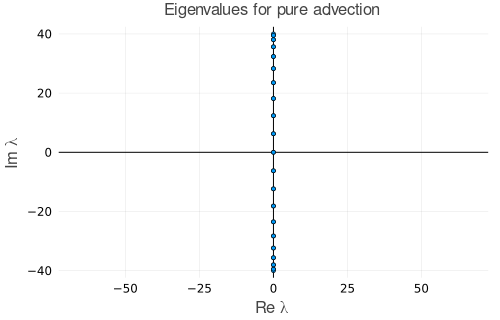

In [2]:
x,Dₓ = FNC.diffper(40,[0,1])
λ = eigvals(Dₓ);

scatter(real(λ),imag(λ),aspect_ratio = 1,
    xlabel="Re λ",ylabel="Im λ",frame=:zerolines,
    title="Eigenvalues for pure advection",leg=:none)

Let's choose a time step of $\tau=0.1$ and compare to the stability regions of the Euler and backward Euler time steppers (shown as shaded regions):

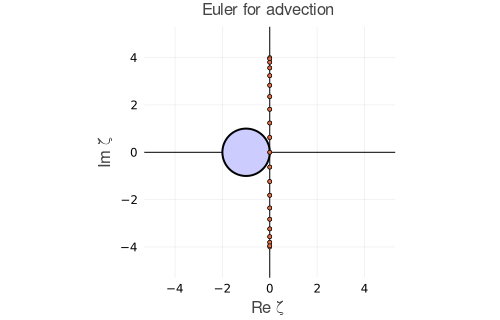

In [3]:
zc = @.exp(1im*2π*(0:360)/360);     # points on |z|=1
z = zc .- 1;                        # shift left by 1
plot(Shape(real(z),imag(z)),color=RGB(.8,.8,1))

ζ = 0.1*λ
scatter!(real(ζ),imag(ζ),aspect_ratio=1,
    xlabel="Re ζ",ylabel="Im ζ",frame=:zerolines,
    xlim=[-5,5],ylim=[-5,5],title="Euler for advection")

In the Euler case it's clear that *no* real value of $\tau>0$ is going to make $\zeta$ values fit within the stability region. Any method whose stability region includes none of the imaginary axis is an unsuitable choice for advection.

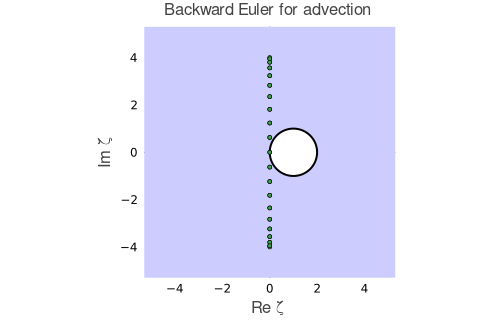

In [4]:
z = zc .+ 1;                        # shift right by 1
plot(Shape([-6,6,6,-6],[-6,-6,6,6]),color=RGB(.8,.8,1))
plot!(Shape(real(z),imag(z)),color=:white)

scatter!(real(ζ),imag(ζ),aspect_ratio=1,
    xlabel="Re ζ",ylabel="Im ζ",frame=:zerolines,
    xlim=[-5,5],ylim=[-5,5],title="Backward Euler for advection")

The A-stable backward Euler time stepping tells the exact opposite story: it will be absolutely stable for any choice of the time step $\tau$.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Many PDEs that conserve quantities will have imaginary eigenvalues, causing Euler and some other IVP methods to fail regardless of step size. Diffusion problems, in which the eigenvalues are negative and real, are compatible with a wider range of integrators, though possibly with onerous step size requirements due to stiffness.

The location of eigenvalues near $\pm ic/h$ also confirms what the CFL condition was suggesting. In order to use RK4, for example, whose stability region intersects the imaginary axis at around $\pm 2.8i$, the time step stability restriction is $\tau c/h \le 2.8$, or $\tau=O(h)$. This is much more favorable than for diffusion, whose eigenvalues were as large as $O(h^{-2})$, and it makes explicit IVP methods much more attractive for advection problems than for diffusion.

## Advection–diffusion equations

```{index} ! advection-diffusion equation
```
The traffic flow equation {eq}`trafficpde` combines a nonlinear advection with a diffusion term. The simplest linear problem with the same feature is the **advection–diffusion equation**

$$
u_t+c u_x=\epsilon u_{xx}.
$$

The parameter $\epsilon$ controls the relative strength between the two mechanisms, and the eigenvalues accordingly vary between the purely imaginary ones of advection and the negative real ones of diffusion.

(demo-absstab-advdiff)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The eigenvalues of advection-diffusion are near-imaginary for $\epsilon\approx 0$ and get closer to the negative real axis as $\epsilon$ increases.

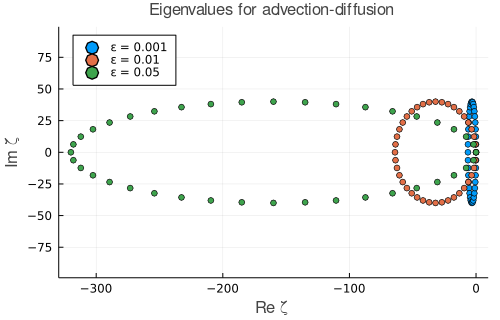

In [5]:
plt = plot(leg=:topleft,aspect_ratio=1,
    xlabel="Re ζ",ylabel="Im ζ",title="Eigenvalues for advection-diffusion")
x,Dₓ,Dₓₓ = FNC.diffper(40,[0,1]);
for ϵ in [0.001 0.01 0.05]
    λ = eigvals(-Dₓ + ϵ*Dₓₓ)
    scatter!(real(λ),imag(λ),m=:o,label="\\epsilon = $ϵ")
end
plt

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


In a nonlinear problem, the eigenvalues come from the linearization about an exact solution, as in {numref}`section-diffusion-stiffness`.

## Boundary effects

Boundary conditions can have a dramatic effect on the eigenvalues of the semidiscretization. For instance, {numref}`Demo {number} <demo-upwind-direction>` solves linear advection $u_t=u_x$ on $[0,1]$ with the homogeneous inflow condition $u(0,t)=0$. Exclusion of the boundary node from the semidiscretization $\mathbf{u}$ to get the interior vector $\mathbf{v}$ is equivalent to 

$$
\mathbf{v} = \mathbf{E} \mathbf{u}, \quad   \mathbf{u} = \begin{bmatrix}  \mathbf{v} \\ 0 \end{bmatrix} = \mathbf{E}^T \mathbf{v},
$$

where $\mathbf{E}$ is the $(m+1)\times (m+1)$ identity with the last row deleted. The ODE on the interior nodes is 

$$
\frac{d\mathbf{v}}{dt} = \mathbf{E} \left( \mathbf{D}_x \mathbf{u} \right) = \mathbf{E} \mathbf{D}_x \mathbf{E}^T \mathbf{v}.
$$

As a result, we conclude that $\mathbf{A} = \mathbf{E} \mathbf{D}_x \mathbf{E}^T$ is the appropriate matrix for determining the eigenvalues of the semidiscretization. More simply, we can simply delete the last row and last column from $\mathbf{D}_x$. 

(demo-absstab-inflow)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Deleting the last row and column places all the eigenvalues of the discretization into the left half of the complex plane.

In [6]:
x,Dₓ,_ = FNC.diffcheb(40,[0,1])
A = Dₓ[1:end-1,1:end-1];     # delete last row and column
λ = eigvals(A);

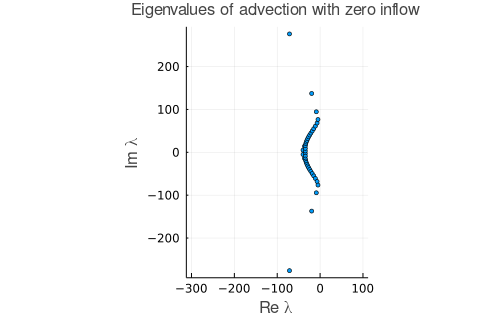

In [7]:
scatter(real(λ),imag(λ),m=3,label="",
    xaxis=([-300,100],"Re λ"),yaxis=("Im λ"),
    title="Eigenvalues of advection with zero inflow",aspect_ratio=1) 

Note that the rightmost eigenvalues have real part at most

In [8]:
maximum( real(λ) )

-4.931967035822874

Consequently all solutions decay exponentially to zero as $t\to\infty$. This matches our observation of the solution: eventually, everything flows out of the domain.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

(problem-absstab-D1eigs)=
1.  ✍ Let $\mathbf{D}_{x}$ be $m\times m$ and given by {eq}`cflcentral`. For any integer $k \in \{0,\ldots,m-1\}$, define $\omega = \exp(2ik\pi/m)$ and $\mathbf{v} = \bigl[ 1,\; \omega,\; \omega^2,\; \ldots,\; \omega^{m-1} \bigr].$ Show that $\mathbf{v}$ is an eigenvector of $\mathbf{D}_{x}$, with eigenvalue

    $$
    \lambda =  i\, m  \sin \frac{2k\pi}{m}.
    $$
    
    (See also [Exercise 11.3.7](problem-absstab-D2eigs).)

2. ⌨ Refer to the semidiscretization of the advection–diffusion equation on $x\in[0,1]$ with $c=1$, $\epsilon=0.01$, and periodic end conditions in {numref}`Demo %s <demo-absstab-advdiff>`. For $m=100$, find the upper bound on $\tau$ that gives absolute stability for Euler time stepping. (Hint: The stability region of Euler is the set of complex values whose distance from $-1$ is less than or equal to one. The effect of $\tau$ is to uniformly scale that distance for the eigenvalues.)

3. ⌨ Refer to the semidiscretization in {numref}`Demo %s <demo-absstab-inflow>`. Find the upper bound on $\tau$ that gives absolute stability for Euler time stepping. (See the hint in the previous exercise.)

4. ⌨ Modify {numref}`Demo %s <demo-absstab-inflow>` so that it produces the eigenvalues of the problem $u_t+u_x=0$ with an outflow condition $u(1,t)=0$. What is the behavior of solutions as $t\to\infty$?